In [2]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
env = gym.make('CartPole-v1').unwrapped
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from matplotlib import font_manager

In [5]:
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return(size-(kernel_size-1)-1) // stride+1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        return self.head(x.view(x.size(0), -1))

In [8]:
import pyglet

C:\Users\516-29\anaconda3\envs\torch_book\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


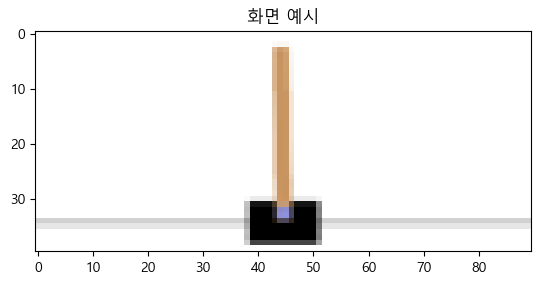

In [9]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.BICUBIC),
    T.ToTensor(),
])

def get_cart_location(screen_width):
    world_width = env.unwrapped.x_threshold * 2
    scale = screen_width / world_width
    return int(env.unwrapped.state[0] * scale + screen_width / 2.0)

def get_screen():
    frame = env.render()
    screen = frame.transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    view_width = int(screen_width*0.6)
    cart_location = get_cart_location(screen_width)

    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)

    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    return resize(screen).unsqueeze(0).to(device)

obs, _ = env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('화면 예시')
plt.show()

In [10]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
init_screen = get_screen()
_, _, screen_hight, screen_width = init_screen.shape
n_actions = env.action_space.n

policy_net = DQN(screen_hight, screen_width, n_actions).to(device)
target_net = DQN(screen_hight, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [12]:
num_episodes = 50

train_env = gym.make("CartPole-v1", render_mode="rgb_array")
view_env = gym.make("CartPole-v1", render_mode="human")

for i_episode in range(num_episodes):
    obs, info = train_env.reset()
    view_env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    for t in count():
        view_env.render()
        action = select_action(state)
        obs, reward, terminated, truncated, info = train_env.step(action.item())
        done = terminated or truncated

        reward = torch.tensor([reward], device=device)
        last_screen = current_screen
        current_screen = get_screen

        if not done:
            next_state = (current_screen-last_screen)
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()

        if done:
            episode_durations.append(t + 1)
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


train_env.close()
view_env.close()
print('종료')

TypeError: unsupported operand type(s) for -: 'function' and 'Tensor'